In [1]:
import pytest
pytest.importorskip('scipy.ndimage')

<module 'scipy.ndimage' from '/opt/local/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/ndimage/__init__.py'>

In [2]:
from lbmpy.session import *
from lbmpy.phasefield.analytical import *
from lbmpy.phasefield.eos import *
from lbmpy.phasefield.high_density_ratio_model import *
from pystencils import Assignment
from pystencils.fd.derivative import replace_generic_laplacian
from pystencils.fd.spatial import discretize_spatial, fd_stencils_standard, fd_stencils_isotropic
from lbmpy.phasefield.fd_stencils import fd_stencils_isotropic_high_density_code
from lbmpy.phasefield.cahn_hilliard_lbm import cahn_hilliard_lb_method
from lbmpy.forcemodels import *
from lbmpy.macroscopic_value_kernels import pdf_initialization_assignments
from scipy.ndimage import gaussian_filter

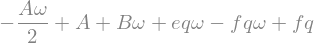

In [3]:
A, B, C, D, F = sp.symbols("A, B, C, D, F")

tau = sp.Symbol("tau")
omega = sp.Symbol("omega")
eq = sp.Symbol("eq")
fq = sp.Symbol("fq")

test = fq - omega * (fq - (eq + ((1/omega) - sp.Rational(1, 2)) * A + B))
test.expand()

# Implementation of high density difference model

According to *"Ternary free-energy entropic lattice Boltzmann model with high density ratio" by Wöhrwag, Semprebon, Mazloomi, Karlin and Kusumaatmaja*

Up front we define all necessary parameters in one place:

In [4]:
a = 0.037
b = 0.2
reduced_temperature = 0.61
gas_constant = 1
κ = (0.01, 1, 1)
λ = (0.6, 1, 1)
χ = 5
φ_relaxation_rate = 1
ρ_relaxation_rate = 1
external_force = (0, 0)
clipping = False

domain_size = (100, 100)
stencil = LBStencil(Stencil.D2Q9, ordering='uk')

fd_discretization = fd_stencils_isotropic_high_density_code
target = ps.Target.CPU
threads = False

## Part 1: Free Energy

The free energy of this model contains a term that is derived from an equation of state. The equation of state and its parametrization determines the density of the liquid and gas phase. 

Here we use the Carnahan-Starling EOS, with the parametrization from the paper

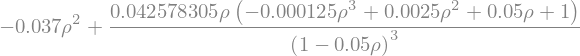

In [5]:
ρ, φ, c_l1, c_l2 = sp.symbols("rho, phi, c_l1, c_l2")

critical_temperature = carnahan_starling_critical_temperature(a, b, gas_constant)
temperature = reduced_temperature * critical_temperature

eos = carnahan_starling_eos(ρ, gas_constant, temperature, a, b)
eos

Next, we use a function that determines the gas and liquid density, using the Maxwell construction rule. This function uses an iterative procedure, that terminates when the equal-area condition is fulfilled with a certain tolerance. 

In [6]:
ρ_g, ρ_l = maxwell_construction(eos, tolerance=1e-3)
(ρ_g, ρ_l, ρ_l / ρ_g)

With this information we call a function that assembles the full free energy density:

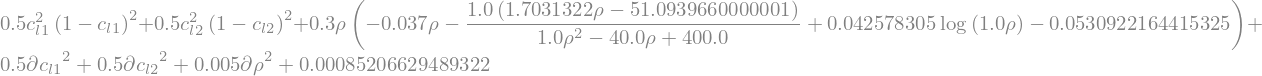

In [7]:
free_energy = free_energy_high_density_ratio(eos, ρ, ρ_g, ρ_l, c_l1, c_l2, λ, κ)
free_energy

This is the free energy expressed in the order parameters $\rho, c_{l1}, c_{l2}$. Next we have to transform it into coordinates $\rho, \phi$. 

In [8]:
transformation_eqs = [ c_l1 - (1 + φ/χ - (ρ - ρ_l)/(ρ_g - ρ_l)) / 2,
                       c_l2 - (1 - φ/χ - (ρ - ρ_l)/(ρ_g - ρ_l)) / 2]
transform_forward_substitutions = sp.solve(transformation_eqs, [c_l1, c_l2])
transform_backward_substitutions = sp.solve(transformation_eqs, [ρ, φ])

To do the transformation, we use the substitutions dict.
After the substitutions the differentials have to be expanded again.

In [9]:
free_energy_transformed = free_energy.subs(transform_forward_substitutions)
free_energy_transformed = expand_diff_full(free_energy_transformed, functions=(ρ, φ))
free_energy_transformed.atoms(sp.Symbol)

Now the free energy depends only on ρ and φ. This transformed form is later used to derive expressions for the chemical potential, pressure tensor and force computations.

## Part 2: Data setup

In [10]:
dh = create_data_handling(domain_size, periodicity=True, default_target=target)

# Fields for order parameters
ρ_field = dh.add_array("rho")
φ_field = dh.add_array("phi")
c_field = dh.add_array("c", values_per_cell=2)

# Chemical potential, pressure tensor, forces and velocities
μ_phi_field = dh.add_array("mu_phi", latex_name=r"\mu_{\phi}")
pbs_field = dh.add_array("pbs")
pressure_tensor_field = dh.add_array("p", len(symmetric_tensor_linearization(dh.dim)))
force_field = dh.add_array("force", values_per_cell=dh.dim, latex_name="F")
vel_field = dh.add_array("velocity", values_per_cell=dh.dim)

# PDF fields for lattice Boltzmann schemes
pdf_src_rho = dh.add_array("pdf_src_rho", values_per_cell=len(stencil))
pdf_dst_rho = dh.add_array_like("pdf_dst_rho", "pdf_src_rho")

pdf_src_phi = dh.add_array("pdf_src_phi", values_per_cell=len(stencil))
pdf_dst_phi = dh.add_array_like("pdf_dst_phi", "pdf_src_phi")

## Part 3a: Compute kernels and time loop

We define one function that takes an expression with derivative objects in it, substitutes the spatial derivatives with finite differences using the strategy defined in the `fd_discretization` function and compiles a kernel from it.

In [11]:
def make_kernel(assignments):
    # assignments may be using the symbols ρ and φ
    # these is substituted with the access to the corresponding fields here
    field_substitutions = {
        ρ: ρ_field.center,
        φ: φ_field.center
    }
    
    processed_assignments = []
    for a in assignments:
        new_rhs = a.rhs.subs(field_substitutions)
        
        # ∂∂f representing the laplacian of f is replaced by the explicit carteisan form
        # ∂_0 ∂_0 f + ∂_1 ∂_1 f     (example for 2D)
        # otherwise the discretization would not do the correct thing
        new_rhs = replace_generic_laplacian(new_rhs)
        
        # Next the "∂" objects are replaced using finite differences
        new_rhs = discretize_spatial(new_rhs, dx=1, stencil=fd_discretization)
        processed_assignments.append(Assignment(a.lhs, new_rhs))
        
    config = ps.CreateKernelConfig(target=target, cpu_openmp=threads)
    return create_kernel(processed_assignments, config=config).compile()

#### Chemical Potential

In the next cell the kernel to compute the chemical potential is created. First an analytic expression for μ is obtained using the free energy, which is then passed to the discretization function above to create a kernel from it. We only have to store the chemical potential of the φ coordinate explicitly, which enters the Cahn-Hilliard lattice Boltzmann for φ.

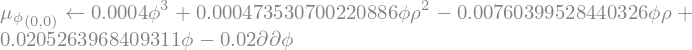

In [12]:
μ_ρ, μ_φ = chemical_potentials_from_free_energy(free_energy_transformed, 
                                                order_parameters=(ρ, φ))
μ_phi_assignment = Assignment(μ_phi_field.center, μ_φ)
μ_kernel = make_kernel([μ_phi_assignment])
μ_phi_assignment

#### Pressure tensor and force computation

For the pressure tensor a trick for enhancing numerical stability is used: the bulk component is not stored directly in the pressure tensor field, but the related quantity called `pbs` is stored in a separate field.

$ pbs = \sqrt{|ρ  c_s^2 - p_{bulk} |} $

The force is then calculated as $ \nabla \cdot  P_{if} + 2  (\nabla pbs) pbs$

In the following kernel the pressure tensor field is filled with $P_{if}$ and the pbs field with above expression.

In [13]:
# Bulk part
pressure_assignments = [
    Assignment(pbs_field.center, 
               pressure_tensor_bulk_sqrt_term(free_energy_transformed, (ρ, φ), ρ)),
]

# Interface part
P_if = pressure_tensor_from_free_energy(free_energy_transformed, (ρ, φ), 
                                        dim=dh.dim, include_bulk=False)
index_map = symmetric_tensor_linearization(dh.dim)

pressure_assignments += [
    Assignment(pressure_tensor_field(index_1d), P_if[index_2d])
    for index_2d, index_1d in index_map.items()
]
pressure_kernel = make_kernel(pressure_assignments)


# Force kernel
pressure_tensor_sym = sp.Matrix(dh.dim, dh.dim, 
                                lambda i, j: pressure_tensor_field(index_map[i, j] 
                                                                   if i < j else index_map[j, i]))
force_term = force_from_pressure_tensor(pressure_tensor_sym, 
                                        functions=[ρ, φ], 
                                        pbs=pbs_field.center)
force_assignments = [
    Assignment(force_field(i), 
               force_term[i] + external_force[i] *  ρ_field.center / ρ_l)
    for i in range(dh.dim)
]
force_kernel = make_kernel(force_assignments)

#### Lattice Boltzmann schemes for time evolution of ρ and φ

- ρ is handled by a normal LB method (compressible, entropic equilibrium)
- stream and collide are splitted into separate kernels
- macroscopic values are computed after the stream, but inside the stream kernel
- velocity field stores the velocity which was not corrected for the forces yet
- the φ collision kernel corrects the velocity itself, because then the updated forces are used for the correction. When u is computed, the updated forces are not computed yet
- when ρ and φ are updated, they are clipped to a valid region, this clipping should be only necessary during equilibration of the system
- exact difference method is used to couple the force into the ρ-LBM

The following cell handles the clipping of the order parameters:

In [14]:
if clipping:
    def clip(ac, symbol, min_value, max_value):
        """Function to clip the value of a symbol which is on one of lhs of the assignments 
        in an assignment collection"""
        assert symbol in ac.bound_symbols
        for i in range(len(ac.subexpressions)):
            a = ac.subexpressions[i]
            if a.lhs == symbol:
                new_assignment = Assignment(symbol, sp.Piecewise((max_value, a.rhs > max_value), 
                                                                 (min_value, a.rhs < min_value), 
                                                                 (a.rhs, True)))
                ac.subexpressions[i] = new_assignment
                break

    # TODO: how can this 'densgin' be derived automatically?            
    tred = reduced_temperature
    densgin = -67.098 \
              + 549.69 * tred \
              - 1850.6 * tred * tred \
              + 3281 * tred * tred * tred \
              - 3237.3 * tred * tred * tred * tred \
              + 1687.6 * tred * tred * tred * tred * tred \
              - 361.51 * tred * tred * tred * tred * tred * tred
    ρ_clip_min, ρ_clip_max = densgin * 0.5, 1.2 * ρ_l 
    φ_clip_min, φ_clip_max = -χ * 1.5, χ * 1.5          

Next, the collide and stream kernels for the ρ lattice Boltzmann are created

In [15]:
force_model = EDM(force_field.center_vector)

lbm_config = LBMConfig(stencil=stencil, method=Method.TRT_KBC_N2, compressible=True, 
                       relaxation_rate=ρ_relaxation_rate, kernel_type='collide_only',
                       density_input=ρ_field, force_model=force_model, velocity_input=vel_field)

lbm_opt = LBMOptimisation(symbolic_field=pdf_src_rho,
                          symbolic_temporary_field=pdf_dst_rho)

config = ps.CreateKernelConfig(target=target, cpu_openmp=threads)

# Standard collision step, that does not compute ρ and u from pdfs, but reads
# them from fields - this is necessary because ρ may have been clipped before
# the velocity field is not force corrected, which is the correct for the EDM model
# but might be wrong for other force models
ρ_collide = create_lb_function(lbm_config=lbm_config,
                               lbm_optimisation=lbm_opt,
                               config=config)

lbm_config = LBMConfig(stencil=stencil, method=Method.TRT_KBC_N2, compressible=True, 
                       relaxation_rate=ρ_relaxation_rate, kernel_type='stream_pull_only',
                       output={'density': ρ_field, 'velocity': vel_field})

# First the assignments are created, then the density is clipped
# then a kernel is created from the clipped assignments
ρ_stream_ur = create_lb_update_rule(lbm_config=lbm_config,
                                    lbm_optimisation=lbm_opt,
                                    config=config)

if clipping:
    clip(ρ_stream_ur, sp.Symbol("rho"), ρ_clip_min, ρ_clip_max)
    
    
lbm_config = LBMConfig(update_rule=ρ_stream_ur)
ρ_stream = create_lb_function(lbm_config=lbm_config,
                              lbm_optimisation=lbm_opt,
                              config=config)

The φ lattice Boltzmann solve the Cahn-Hilliard equation. 

In [16]:
φ_lb_method = cahn_hilliard_lb_method(stencil=stencil, 
                                      mu=μ_phi_field.center, 
                                      relaxation_rate=φ_relaxation_rate, 
                                      gamma=1)

corrected_vel = vel_field.center_vector + sp.Matrix(force_model.macroscopic_velocity_shift(ρ_field.center))

lbm_opt = LBMOptimisation(symbolic_field=pdf_src_phi,
                          symbolic_temporary_field=pdf_dst_phi)

config = ps.CreateKernelConfig(target=target, cpu_openmp=threads)


lbm_config = LBMConfig(lb_method=φ_lb_method, compressible=True, 
                       kernel_type='collide_only',
                       density_input=φ_field, velocity_input=corrected_vel)

φ_collide = create_lb_function(lbm_config=lbm_config,
                               lbm_optimisation=lbm_opt,
                               config=config)

lbm_config = LBMConfig(lb_method=φ_lb_method, compressible=True, 
                       kernel_type='stream_pull_only', output={'density': φ_field})

φ_stream_ur = create_lb_update_rule(lbm_config=lbm_config,
                                    lbm_optimisation=lbm_opt,
                                    config=config)
if clipping:
    clip(φ_stream_ur, sp.Symbol("rho"), φ_clip_min, φ_clip_max)
    

lbm_config = LBMConfig(update_rule=φ_stream_ur)
φ_stream = create_lb_function(lbm_config=lbm_config,
                              lbm_optimisation=lbm_opt,
                              config=config)

#### Time loop

Now we can put all kernels together into a time loop function

In [17]:
op_sync = dh.synchronization_function([ρ_field.name, φ_field.name])
p_sync = dh.synchronization_function([pbs_field.name, pressure_tensor_field.name])
pdf_sync = dh.synchronization_function([pdf_src_phi.name, pdf_src_rho.name])

def time_loop(steps):
    for t in range(steps):
        op_sync()
        dh.run_kernel(μ_kernel)
        dh.run_kernel(pressure_kernel)
        
        p_sync()
        dh.run_kernel(force_kernel)
        
        dh.run_kernel(ρ_collide)
        dh.run_kernel(φ_collide)
        
        pdf_sync()
        dh.run_kernel(ρ_stream)
        dh.run_kernel(φ_stream)
        dh.swap(pdf_dst_phi.name, pdf_src_phi.name)
        dh.swap(pdf_dst_rho.name, pdf_src_rho.name)
    return dh.cpu_arrays[φ_field.name][1:-1, 1:-1]

## Part 3b: Compiling getter & setter kernels

The setter kernel computes ρ, φ from C and sets the pdfs to equilibrium using the values in the order parameter and velocity fields.

In [18]:
init_assignments = [ 
    Assignment( φ_field.center, transform_backward_substitutions[φ].subs({ c_l1: c_field(0), c_l2: c_field(1)} )),
    Assignment( ρ_field.center, transform_backward_substitutions[ρ].subs({ c_l1: c_field(0), c_l2: c_field(1)} )),
]

init_rho = pdf_initialization_assignments(ρ_collide.method, 
                                          density=ρ_field.center, 
                                          velocity=vel_field.center_vector, 
                                          pdfs=pdf_src_rho.center_vector)
init_rho = init_rho.new_without_subexpressions()
init_assignments += init_rho.all_assignments

init_phi = pdf_initialization_assignments(φ_collide.method,
                                          density=φ_field.center,
                                          velocity=(0,0,0), 
                                          pdfs=pdf_src_phi.center_vector)
init_phi = init_phi.new_without_subexpressions().new_with_substitutions({μ_phi_field.center: 0})
init_assignments += init_phi.all_assignments

init_pdfs_assignments = init_rho.all_assignments + init_phi.all_assignments

init_pdfs_kernel = create_kernel(init_pdfs_assignments).compile()
init_kernel = create_kernel(init_assignments).compile()

## Part 4: Geometry initialization & plotting

In [19]:
def plot_status():
    plt.figure(figsize=(25, 6))
    plt.subplot(1, 4, 1)
    ρ_arr = dh.cpu_arrays[ρ_field.name][1:-1, 1:-1]
    plt.scalar_field(ρ_arr)
    plt.title("ρ ({:.2f}, {:.2f})".format(np.min(ρ_arr), np.max(ρ_arr)))
    plt.colorbar()
    
    plt.subplot(1, 4, 2)
    φ_arr = dh.cpu_arrays[φ_field.name][1:-1, 1:-1]
    plt.scalar_field(φ_arr)
    plt.title("φ ({:.2f}, {:.2f})".format(np.min(φ_arr), np.max(φ_arr)))
    plt.colorbar()

    plt.subplot(1, 4, 3)
    f_arr = dh.cpu_arrays[force_field.name][1:-1, 1:-1]
    plt.vector_field_magnitude(f_arr)
    plt.title("F ({:.2f}, {:.2f})".format(np.min(f_arr), np.max(f_arr)))
    plt.colorbar()
    
    plt.subplot(1, 4, 4)
    μ_arr = dh.cpu_arrays[μ_phi_field.name][1:-1, 1:-1]
    plt.scalar_field(μ_arr)
    plt.title("μ_φ ({:.2f}, {:.2f})".format(np.min(μ_arr), np.max(μ_arr)))
    plt.colorbar()

def init_drop():
    radius = dh.shape[0] // 5
    mid1 = [dh.shape[0] // 2, dh.shape[1] // 2]

    for block in dh.iterate(ghost_layers=True):
        x, y = block.midpoint_arrays
        mask1 = (x - mid1[0]) ** 2 + (y - mid1[1])**2 < radius ** 2

        block[force_field.name].fill(0)
        block[vel_field.name].fill(0)
        block[μ_phi_field.name].fill(0)

        c_arr = block[c_field.name]
        c_arr[:, :].fill(0.0)
        c_arr[mask1, 0] = 1.0

        gaussian_filter(c_arr[..., 0], sigma=3, output=c_arr[..., 0])
        gaussian_filter(c_arr[..., 1], sigma=3, output=c_arr[..., 1])

    dh.run_kernel(init_kernel)

# Part 5: Putting it all together

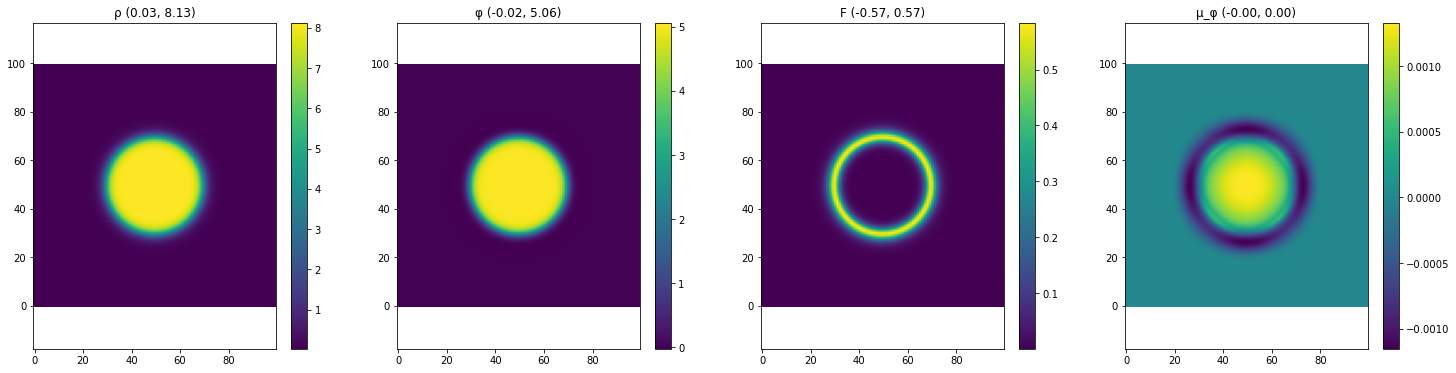

In [20]:
init_drop()
time_loop(1000)
plot_status()

In [21]:
ρ_arr = dh.gather_array(ρ_field.name)
assert not np.isnan(np.min(ρ_arr))
assert not np.isnan(np.max(ρ_arr))